In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=109f226ef32e3bf9e06998f3a50b7328810ca9dc1446fcfe67abf4c809761f2e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import pyspark

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("Gender Classification").getOrCreate()

In [ ]:
df = spark.read.csv('/gender_classification.csv', header=True, inferSchema=True)

In [ ]:
df.show()

+---------+-----------------+------------------+---------+---------+---------+-------------------------+------+
|long_hair|forehead_width_cm|forehead_height_cm|nose_wide|nose_long|lips_thin|distance_nose_to_lip_long|gender|
+---------+-----------------+------------------+---------+---------+---------+-------------------------+------+
|        1|             11.8|               6.1|        1|        0|        1|                        1|  Male|
|        0|             14.0|               5.4|        0|        0|        1|                        0|Female|
|        0|             11.8|               6.3|        1|        1|        1|                        1|  Male|
|        0|             14.4|               6.1|        0|        1|        1|                        1|  Male|
|        1|             13.5|               5.9|        0|        0|        0|                        0|Female|
|        1|             13.0|               6.8|        1|        1|        1|                        1|

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, Imputer

In [ ]:
missing_counts = [(col, df.filter(df[col].isNull()).count()) for col in df.columns]
print("Missing Values:")
for col, count in missing_counts:
    print(f"{col}: {count}")

Missing Values:
long_hair: 0
forehead_width_cm: 0
forehead_height_cm: 0
nose_wide: 0
nose_long: 0
lips_thin: 0
distance_nose_to_lip_long: 0
gender: 0


In [ ]:
label_indexer = StringIndexer(inputCol="gender", outputCol="label")
feature_cols = ["long_hair", "forehead_width_cm", "forehead_height_cm", "nose_wide", "nose_long", "lips_thin", "distance_nose_to_lip_long"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [ ]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=False)

In [ ]:
(training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=123)

In [ ]:
from pyspark.ml.classification import LogisticRegression
logistic_regression = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [ ]:
from pyspark.ml import Pipeline
pipeline_lr = Pipeline(stages=[label_indexer, vector_assembler, logistic_regression])

In [ ]:
model_lr = pipeline_lr.fit(training_data)

In [ ]:
predictions_lr = model_lr.transform(testing_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator.evaluate(predictions_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")

Logistic Regression Accuracy: 0.9531405782652044


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
prediction_and_label_lr = predictions_lr.select("prediction", "label").rdd

In [ ]:
metrics_lr = MulticlassMetrics(prediction_and_label_lr)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
confusion_matrix = metrics_lr.confusionMatrix()
precision = metrics_lr.precision(0.0)
recall = metrics_lr.recall(0.0)
f1Score = metrics_lr.fMeasure(0.0)
print("Confusion Matrix:")
print(confusion_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Confusion Matrix:
DenseMatrix([[464.,  12.],
             [ 35., 492.]])
Precision: 0.9298597194388778
Recall: 0.9747899159663865
F1 Score: 0.9517948717948718


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline_dt = Pipeline(stages=[label_indexer, vector_assembler, decision_tree])
model_dt = pipeline_dt.fit(training_data)
predictions_dt = model_dt.transform(testing_data)
accuracy_dt = evaluator.evaluate(predictions_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")

Decision Tree Accuracy: 0.9621136590229312


In [ ]:
prediction_and_label_dt = predictions_dt.select("prediction", "label").rdd

In [ ]:
metrics_dt = MulticlassMetrics(prediction_and_label_dt)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
confusion_matrix = metrics_dt.confusionMatrix()
precision = metrics_dt.precision(0.0)
recall = metrics_dt.recall(0.0)
f1Score = metrics_dt.fMeasure(0.0)
print("Confusion Matrix:")
print(confusion_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Confusion Matrix:
DenseMatrix([[464.,  12.],
             [ 26., 501.]])
Precision: 0.9469387755102041
Recall: 0.9747899159663865
F1 Score: 0.9606625258799173


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
random_forest = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
pipeline_rf = Pipeline(stages=[label_indexer, vector_assembler, random_forest])
model_rf = pipeline_rf.fit(training_data)
predictions_rf = model_rf.transform(testing_data)
accuracy_rf = evaluator.evaluate(predictions_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

Random Forest Accuracy: 0.967098703888335


In [ ]:
prediction_and_label_rf = predictions_rf.select("prediction", "label").rdd

In [ ]:
metrics_rf = MulticlassMetrics(prediction_and_label_rf)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
confusion_matrix = metrics_rf.confusionMatrix()
precision = metrics_rf.precision(0.0)
recall = metrics_rf.recall(0.0)
f1Score = metrics_rf.fMeasure(0.0)
print("Confusion Matrix:")
print(confusion_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Confusion Matrix:
DenseMatrix([[470.,   6.],
             [ 27., 500.]])
Precision: 0.9456740442655935
Recall: 0.9873949579831933
F1 Score: 0.9660842754367935


In [ ]:
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(maxIter=10, regParam=0.1)
pipeline_svm = Pipeline(stages=[label_indexer, vector_assembler, svm])
model_svm = pipeline_svm.fit(training_data)
predictions_svm = model_svm.transform(testing_data)
accuracy_svm = evaluator.evaluate(predictions_svm)
print(f"SVM Accuracy: {accuracy_svm}")

SVM Accuracy: 0.9641076769690927


In [ ]:
prediction_and_label_svm = predictions_svm.select("prediction", "label").rdd

In [ ]:
metrics_svm = MulticlassMetrics(prediction_and_label_svm)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
confusion_matrix = metrics_svm.confusionMatrix()
precision = metrics_svm.precision(0.0)
recall = metrics_svm.recall(0.0)
f1Score = metrics_svm.fMeasure(0.0)
print("Confusion Matrix:")
print(confusion_matrix)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1Score}")

Confusion Matrix:
DenseMatrix([[462.,  14.],
             [ 22., 505.]])
Precision: 0.9545454545454546
Recall: 0.9705882352941176
F1 Score: 0.9625


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
algorithm_names = ["Logistic Regression", "Random Forest", "Decision Tree", "Support Vector Machine"]
accuracy_scores = [0.953, 0.967, 0.962, 0.964]
precision_scores = [0.930, 0.946, 0.947, 0.955]
recall_scores = [0.975, 0.987, 0.975, 0.971]
f1_scores = [0.952, 0.966, 0.961, 0.963]

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'Algorithm': algorithm_names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

In [ ]:
import numpy as np

In [ ]:
ind = np.arange(len(algorithm_names))
width = 0.2

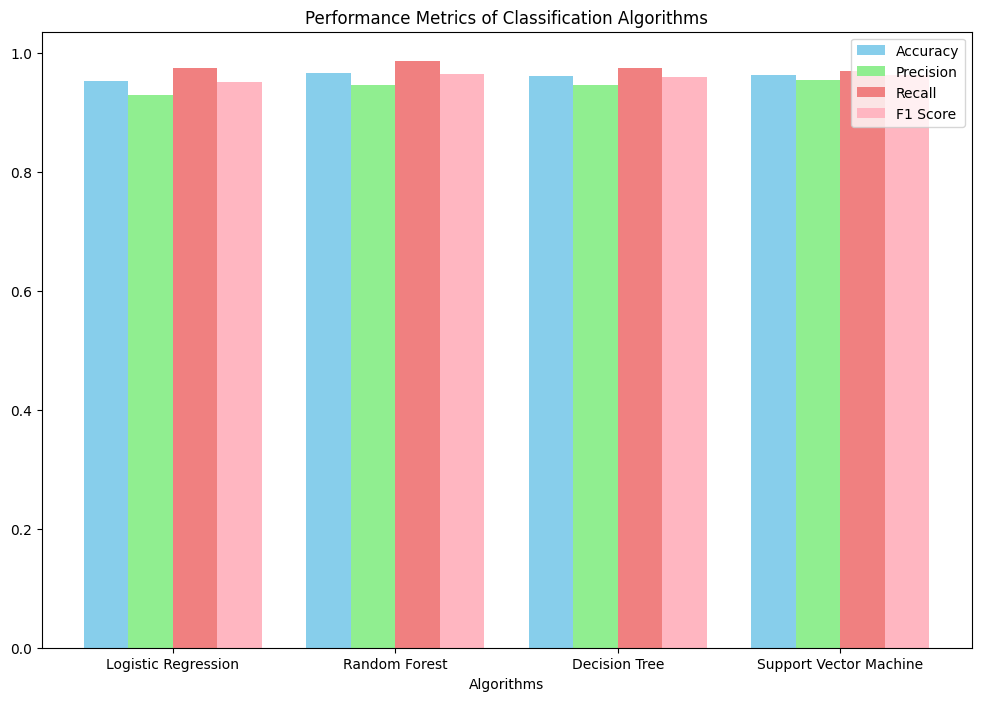

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(ind - width, accuracy_scores, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(ind, precision_scores, width, label='Precision', color='lightgreen')
rects3 = ax.bar(ind + width, recall_scores, width, label='Recall', color='lightcoral')
rects4 = ax.bar(ind + 2*width, f1_scores, width, label='F1 Score', color='lightpink')
ax.set_xlabel('Algorithms')
ax.set_title('Performance Metrics of Classification Algorithms')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(algorithm_names)
ax.legend()
plt.show()

In [ ]:
spark.stop()